<a href="https://colab.research.google.com/github/superwise-ai/quickstart/blob/mlflow_integration/how_to_integrate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Superwise - MLFlow Integration demo

Welcome to our Superwise-MLFlow-TensorFlow integration demo notebook! 


In this tutorial you will learn how you can track your experiments with MLFlow while enriching them with Superwise's **AMAZING** data analysis capabilities.


The core topics that we'll cover:

1.   Collecting experiments data with MLFlow and linking it to Superwise's models
2.   Analyzing datasets and models using Superwise to get metrics like input-drift 
3.  Enriching your MLFlow's experiments with new metrics from Superwise



# Part 1: Connecting with MLFlow

## Setup the environment

### Install dependencies

In [ ]:
!pip install -q superwise
!pip install -q mlflow

### Import packages

In [ ]:
import numpy as np
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt

import mlflow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

from superwise import Superwise
from superwise.models.model import Model
from superwise.models.version import Version
from superwise.resources.superwise_enums import DataEntityRole

### Import Superwise API client

In [ ]:
!wget -q -nc https://raw.githubusercontent.com/superwise-ai/quickstart/main/integrations/mlflow/superwise_client.py
from superwise_client import SuperwiseClient

### Configure environment tokens and variables

Databricks init (you can create a free account [here](https://community.cloud.databricks.com/))

In [ ]:
# Setting up global names 
model_name = "Diamond Model"
superwise_version_name = "1.0.0"

In [ ]:
!databricks configure --host https://community.cloud.databricks.com/

Sets up MLflow connection with Databricks

In [ ]:
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment(f"/Users/{databricks_username}/{model_name}")

Set Superwise credentials. Read [here](https://docs.superwise.ai/docs/authentication) about how to obtain them!

In [ ]:
CLIENT_ID = ''
SECRET = ''
CUSTOMER = ''

In [ ]:
os.environ['SUPERWISE_CLIENT_ID'] = CLIENT_ID
os.environ['SUPERWISE_SECRET'] = SECRET

Init Superwise 

In [ ]:
sw = Superwise()
sw_client = SuperwiseClient(CLIENT_ID, SECRET, CUSTOMER)
sw_client.start_session()

## Build a mini-ML process

For the purpose of this demo we will use an open source [Diamonds](https://ggplot2.tidyverse.org/reference/diamonds.html) dataset. This classic dataset contains physical attributes and prices of 53940 diamonds. 

We will build a simple TensorFlow model to predict the price of these diamonds based on these attributes!

Download Diamond dataset

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/tidyverse/ggplot2/main/data-raw/diamonds.csv')
data = data.dropna()
data

In [ ]:
# Listing features by type
categorical = ['cut', 'color', 'clarity']
numerical = ['carat', 'depth', 'table', 'x', 'y', 'z']
target = 'price'

In [ ]:
# Split dataset into training and testing subsets
train, val, test = np.split(data.sample(frac=1), [int(0.8*len(data)), int(0.9*len(data))])

In [ ]:
# Dataset statistics
train.describe().transpose()

### Create input pipeline using TensorFlow.data

Since in this tutorial we work with TensorFlow, we thought that it would be nice to show how to perform some feature transformations on the dataset. As you know, neural networks cannot perform mathematical operations on strings, and they perform better on normalized inputs. Therefore we would have to perform some feature transformations like encoding and normalization. 

In [ ]:
def df_to_dataset(dataframe, target_label, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop(target_label)
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
batch_size = 1000
train_ds = df_to_dataset(train, target, batch_size=batch_size)
val_ds = df_to_dataset(val, target, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, target, shuffle=False, batch_size=batch_size)

Normalisation

In [ ]:
def get_normalization_layer(name, dataset):
  normalizer = layers.Normalization(axis=None)
  feature_ds = dataset.map(lambda x, y: x[name])
  normalizer.adapt(feature_ds)
  return normalizer

Category encoding

In [ ]:
def get_category_encoding_layer(name, dataset, max_tokens=None):
  index = layers.StringLookup(max_tokens=max_tokens)
  feature_ds = dataset.map(lambda x, y: x[name])
  index.adapt(feature_ds)
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
  return lambda feature: encoder(index(feature))

Preprocess features

In [ ]:
def get_encoded_features(train_dataset):
  all_inputs = []
  encoded_features = []

  for header in numerical:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_dataset)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

  for header in categorical:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header, dataset=train_dataset, max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

  return all_inputs, encoded_features

all_inputs, encoded_features = get_encoded_features(train_ds)

Create and compile the model

In [ ]:
def create_and_compile_model(inputs, features):
  all_features = tf.keras.layers.concatenate(features)
  x = layers.Normalization(axis=None)(all_features)
  x = tf.keras.layers.Dense(256, activation="relu")(x)
  x = tf.keras.layers.Dense(256, activation="relu")(x)
  x = tf.keras.layers.Dense(256, activation="relu")(x)
  x = tf.keras.layers.Dense(256, activation="relu")(x)
  output = tf.keras.layers.Dense(1)(x)

  model = tf.keras.Model(inputs, output)

  model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.1))
  
  return model

model = create_and_compile_model(all_inputs, encoded_features)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Training a model and tracking the experiment!

Now here's the time to actually run our experiment and track its result.

In this part we will run the training. MLFlow will log the training metrics for us, as well as some artifacts and the code. We will then enrich MLFlow's tracking with custom metrics and tags that reference Superwise.

### Matching Superwise and MLFlow IDs

Here make sure that we can identify the Superwise logged model in MLFlow. We do that using MLFlow tags. We use Superwise_model and Supwerwise_version to log the IDs used in Superwise as part of the Experiment. Then we start running the expetiment, passing the tags map to the `start_run` function.

In [ ]:
tags = {"Superwise_model": model_name, "Superwise_version": superwise_version_name}

mlflow_run = mlflow.start_run(tags=tags)

### Training the model and logging the training metrics to MLFlow

In [ ]:
mlflow.tensorflow.autolog()
history = model.fit(train_ds, epochs=40, validation_data=val_ds, verbose=0)

Predict diamond price on training set

In [ ]:
y_pred_val = model.predict(val_ds).flatten()

Prepare baseline dataset for Superwise

In [ ]:
baseline_data = val.assign(
    id=val.index,
    ts=pd.Timestamp.now(),
    prediction=y_pred_val
)

baseline_data.head()

### Create a new Superwise model

Since we are training a new model, let's create a new one in Superwise. We will give it the same name as we did in MLFlow so we'll be able to identify them.

In [ ]:
is_model_new = True

if not sw.model.get_by_name(model_name):
  sw_model = Model(
      name=model_name,
      description="Regression model that predicts the diamond price"
  )

  sw_model = sw.model.create(sw_model)
  print(f"New model was created with ID {sw_model.id}")
else:
  sw_model = sw.model.get_by_name(model_name)[0]
  is_model_new = False
  print(f"Model with ID {sw_model.id} already exists")

In [ ]:
# Infer schema for dataset
entities_collection = sw.data_entity.summarise(
    data=baseline_data,
    specific_roles = {
      'id': DataEntityRole.ID,
      'ts': DataEntityRole.TIMESTAMP,
      'prediction': DataEntityRole.PREDICTION_VALUE,
      'price': DataEntityRole.LABEL
    }
)

In [ ]:
# Activate Superwise model version
sw_version = Version(
    model_id=sw_model.id,
    name=superwise_version_name,
    data_entities=entities_collection,
)

if is_model_new:
  sw_version = sw.version.create(sw_version)
  sw.version.activate(sw_version.id)

### Send data to Superwise
After setting up the model version in Superwise, we then send our data there so the platform can automatically start to analyze it and calculate important metrics that we would like to track.

Generates dummy production data

In [ ]:
y_pred_test = model.predict(test_ds).flatten()

prediction_time_vector = pd.Timestamp.now().floor('h') - \
    pd.TimedeltaIndex(test.reset_index(drop=True).index // int(test.shape[0] // 30), unit='D')

ongoing_predictions = test.assign(
    id=test.index,
    ts=prediction_time_vector,
    prediction=y_pred_test
)

ongoing_predictions.to_csv('ongoing_predictions.csv')

ongoing_predictions.head()

Logging prediction data

In [ ]:
transaction_id = sw.transaction.log_from_local_file('ongoing_predictions.csv', sw_version.id, sw_model.id)

### Finish up the experiment

In [ ]:
mlflow.end_run()

### View the logged model in MLFlow

Passing the custom tags to the MLFlow run will make them appear in the experiment tracking dashboard. You can see them by logging into the MLFlow community edition server or to your own server if you are using a paid version! 

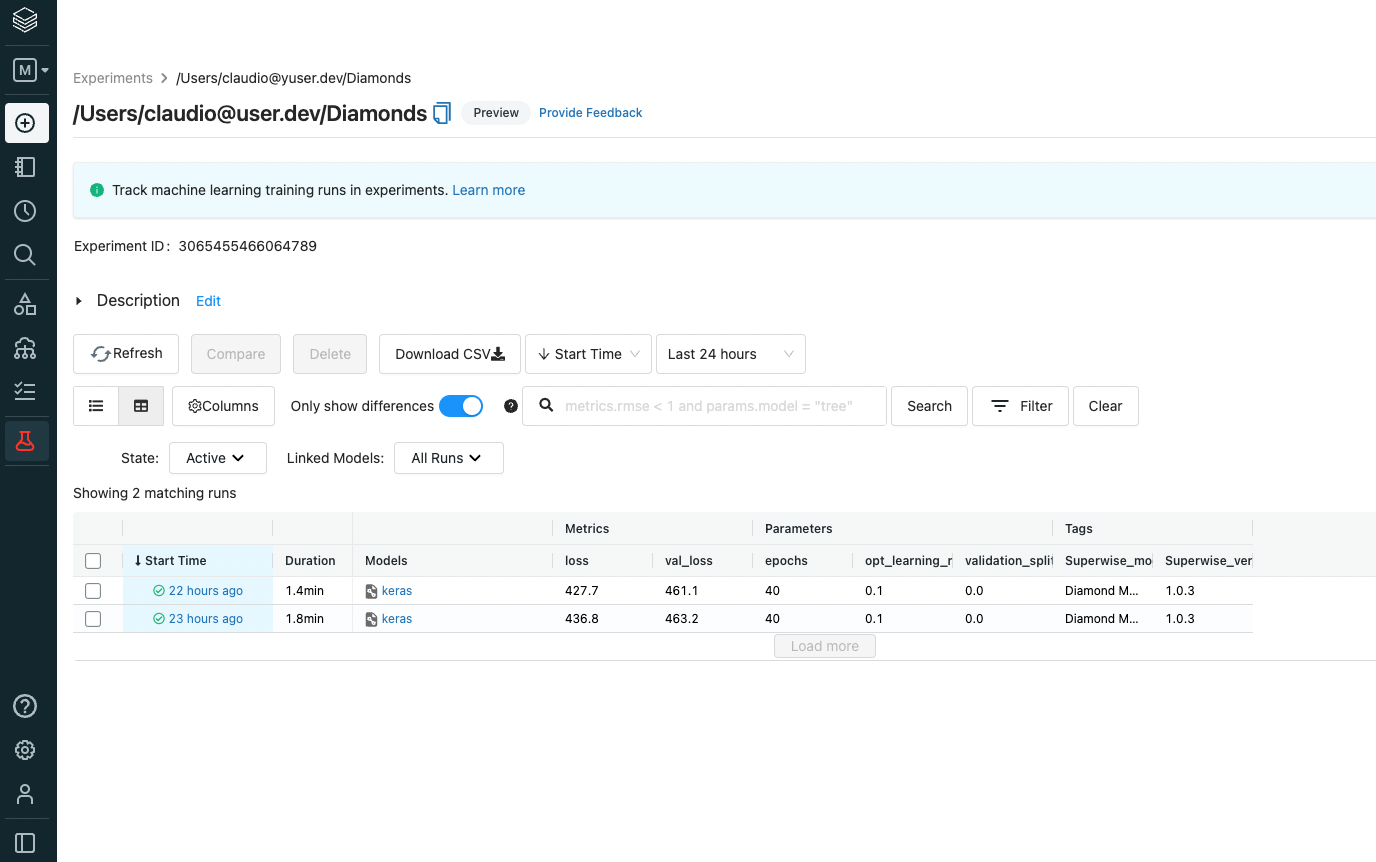

# Part 2: Enrich MLFlow experiments with Superwise

## Corrupt data experiment

Now here comes an interesting part. Let's assume that one of our naughty data science team members accidentally performed a wrong transformation on one of the features. He actually placed **random numbers** under the "*carat*" column.

This of course will lower the model performance, but tracking it with MLFlow alone will not shed light on what reduced the performance of the model.

However, adding custom metrics, like `input_drift` calculated by Superwise will help us understand that there was a major change in the training set!

**Let's see it in action**

### Corrupting the data (by mistake)

In [ ]:
# Here's where the data scientist currupted the data
train_corrupt = train.copy()
val_corrupt = val.copy()
test_corrupt = test.copy()

train_corrupt['carat'] = np.random.randint(0, 100, len(train))
val_corrupt['carat'] = np.random.randint(0, 100, len(val))
test_corrupt['carat'] = np.random.randint(0, 100, len(test))

train_corrupt_ds = df_to_dataset(train_corrupt, target, batch_size=batch_size)
val_corrupt_ds = df_to_dataset(val_corrupt, target, batch_size=batch_size)
test_corrupt_ds = df_to_dataset(test_corrupt, target, batch_size=batch_size)

In [ ]:
# Carat column has now been corrupted with random values between 0 and 100
train_corrupt.head()

### Train a model on the new data

Encode corrupt train data and create new model

In [ ]:
all_inputs, encoded_features = get_encoded_features(train_corrupt_ds)
model = create_and_compile_model(all_inputs, encoded_features)

Train model with corrupt data

In [ ]:
superwise_version_name = '1.0.1'

In [ ]:
tags = {'Superwise_model': model_name, 'Superwise_version': superwise_version_name}

In [ ]:
mlflow_run = mlflow.start_run(tags=tags)
mlflow.tensorflow.autolog()

In [ ]:
model.fit(train_corrupt_ds, epochs=40, validation_data=val_corrupt_ds, verbose=0)

## Generate dummy corrupt data

In [ ]:
y_pred_test_corrupt = model.predict(test_corrupt_ds).flatten()

prediction_time_vector = pd.Timestamp.now().floor('h') - \
    pd.TimedeltaIndex(test_corrupt.reset_index(drop=True).index // int(test_corrupt.shape[0] // 30), unit='D')

ongoing_corrupt_predictions = test_corrupt.assign(
    id=test_corrupt.index,
    ts=prediction_time_vector,
    prediction=y_pred_test_corrupt
)

ongoing_corrupt_predictions.to_csv('ongoing_corrupt_predictions.csv')

ongoing_corrupt_predictions.head()

### Logging corrupt predictions to Superwise

In [ ]:
transaction_id = sw.transaction.log_from_local_file('ongoing_corrupt_predictions.csv', sw_version.id, sw_model.id)

### Enriching MLFlow with Superwise metrics

Now that the data is already in Superwise the system will start calculating meaningful metrics on its own! One of them is the desired input_drift. We will retrieve this metric from Superwise and send it to MLFlow as a custom metric.

Read more [here](https://docs.superwise.ai/docs/consuming-metrics-via-api) about how to collect metrics from Superwise 

In [ ]:
#listing the experiments
tasks_df = sw_client.get_tasks_df()
tasks_df.sort_values(['id']).tail(5)

Select the name of the model you want to track from the list, should be the last one displayed

In [ ]:
task = tasks_df[tasks_df['name'] == model_name]
TASK_ID = int(task['id'])
VERSION_ID = int(task['active_version_id'])

Request all of the model's features and select the top 5 based on importance

In [ ]:
features = sw_client.get_features(VERSION_ID)
features = features.sort_values(['feature_importance']).tail(5)[["id","name","type","feature_importance"]]
ENTITY_IDS= features.id.to_list()
features.head()

Select input drift from metrics

In [ ]:
metrics = sw_client.get_metrics()
METRIC_ID=metrics.set_index('name').loc['input_drift']['id']

In [ ]:
results_df = sw_client.get_metrics_values(TASK_ID, VERSION_ID, ENTITY_IDS, features)
results_df.head()

Plot input drift for top 5 features

In [ ]:
plot_df = results_df.pivot(index='date_hour', columns='entity_name', values='value')
plot_df.plot(figsize=(35,10), title='Input Drift Trend', legend=True, xlabel='Date', ylabel='Drift')

In this plot it's **VERY easy** to see that something is off with 'carat'. Its drift is around 25 while other features have a drift of about 0 over time! Next up we will calculate the weighted average of the drift and send it to MLFlow:

In [ ]:
input_drift_value = 0

# Calculating the weighted average of feature drift
for feature in features['name'].tolist():
  importance = features.set_index('name').loc[feature]['feature_importance']
  input_drift = results_df[results_df['entity_name'] == feature]['value'].mean()
  input_drift_value += importance * input_drift

input_drift_value /= features['feature_importance'].sum()

# Logging the feature drift to MLFlow
mlflow.log_metrics({"input_drift": input_drift_value})

In [ ]:
mlflow.end_run()

## Analyzing the results in MLFlow

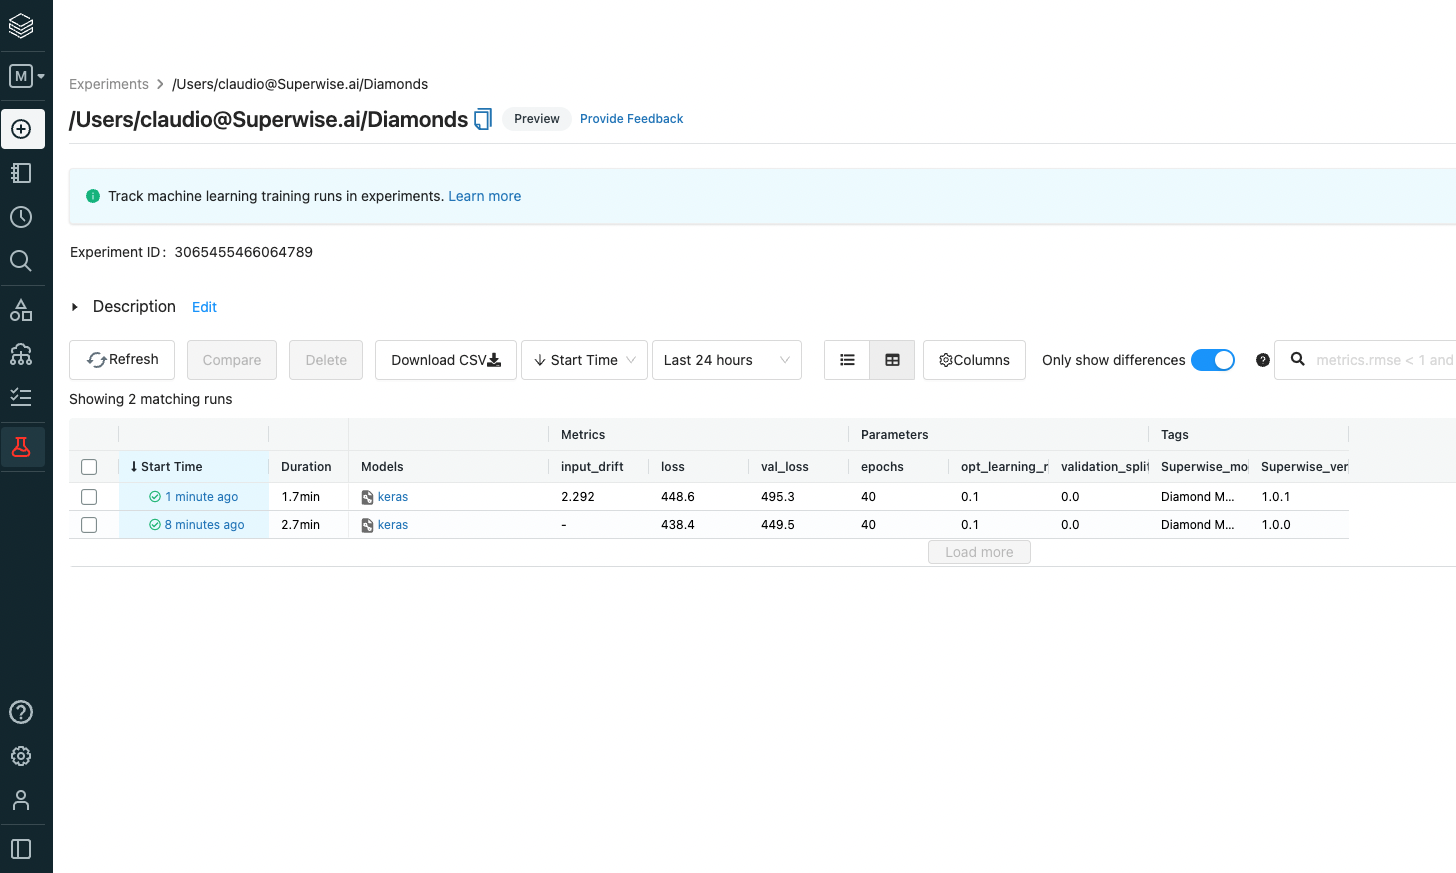

In the above screenshot it's easy to see that we have input_drift showing up. The model loss both on the training and the validation seems higher which can be explained by the fact that we corrupted our features!